In [206]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from skspatial.objects import LineSegment, Line, Vector

# some helper functions
from helpers import (
    get_arc_point,
    draw_arc,
    rotate,
    translate,
    flip_y,
    flip_x,
    optimize_points,
    chaikin,
    rotate_point,
    scale,
)
from pcb_json import (
    dump_json,
    plot_json,
    create_via,
    create_pad,
    create_pin,
    create_silk,
    create_mounting_hole,
)

from enum import Enum

Layer = Enum("Layer", "FRONT BACK")

In [207]:
# Track width and spacing
TRACK_WIDTH = 0.4 #0.102
TRACK_SPACING = 0.1 #0.2

# via defaults
VIA_DIAM = 0.45 #0.8
VIA_DRILL = 0.225 #0.4

# this is for a 1.27mm pitch pin
PIN_DIAM = 1.0
PIN_DRILL = 0.65

# this is for the PCB connector - see https://www.farnell.com/datasheets/2003059.pdf
PAD_ENABLE = False
PAD_WIDTH = 3
PAD_HEIGHT = 2
PAD_PITCH = 2.5

# Vias for connecting to the coils
COIL_INPUT_VIAS_ENABLE = True

# PCB edge cuts
PCB_EDGE_CUTS = False  #false

# Stator hole
STATOR_HOLE_RADIUS = 57 #114mm  #5.5

# Coil net names
COIL_NET_NAME = "coils"
COIL_NET_NAME_A = "A_coils"
COIL_NET_NAME_B = "B_coils"
COIL_NET_NAME_C = "C_coils"

In [208]:
# Large 35 mm version

# PCB Edge size
STATOR_RADIUS = 73 #80

# where to puth the mounting pins
SCREW_HOLE_DRILL_DIAM = 2.3  # 2.3mm drill for a 2mm screw
SCREW_HOLE_RADIUS = STATOR_RADIUS

# Coil params
# for custom shape
TURNS = 8 #13
# for spiral
# TURNS = 17
COIL_CENTER_RADIUS = 65.00 #20.45
COIL_VIA_RADIUS = 65.00 #20.95

# Coil input vias
COIL_INPUT_VIA_RADIUS = 79 #78 #27

In [209]:
# where to put the input pads
INPUT_PAD_RADIUS = COIL_VIA_RADIUS
print(INPUT_PAD_RADIUS)

USE_SPIRAL = False

if USE_SPIRAL:
    TURNS = 18
    COIL_VIA_RADIUS = 20.5
    COIL_CENTER_RADIUS = 20.5

LAYERS = 4

OUTER_CONN_RADIUS = 79

65.0


# Arbitrary Coil Generation

# Generate PCB Layout

In [210]:

# def get_spiral(turns, start_radius, thickness, layer=Layer.FRONT):
#     points = []
#     # create a starting point in the center
#     for angle in np.arange(0, turns * 360, 1):
#         radius = start_radius + thickness * angle / 360
#         if layer == Layer.BACK:
#             x = radius * np.cos(np.deg2rad(angle + 180))
#             y = radius * np.sin(np.deg2rad(angle + 180))
#             points.append((x, -y))
#         else:
#             x = radius * np.cos(np.deg2rad(angle))
#             y = radius * np.sin(np.deg2rad(angle))
#             points.append((x, y))
#     return points
#
#
# def calculate_point(point, point1, point2, spacing, turn):
#     reference_vector = Vector([-100, 0])
#     angle = np.rad2deg(Vector(point).angle_between(reference_vector))
#     if point[1] > 0:
#         angle = 360 - angle
#     vector = Vector(point1) - Vector(point2)
#     normal = vector / np.linalg.norm(vector)
#     # rotate the vector 90 degrees
#     normal = np.array([-normal[1], normal[0]])
#     # move the  point along the normal vector by the spacing
#     offset = spacing * (turn * 360 + angle) / 360
#     coil_point = point + normal * offset
#     return (coil_point[0], coil_point[1])
#
#
# def get_points(template, turns, spacing):
#     coil_points = []
#     reference_vector = Vector([-100, 0])
#     template_index = 0
#     template_length = len(template)
#     for turn in range(turns * template_length):
#         point1 = template[template_index % template_length]
#         point2 = template[(template_index + 1) % template_length]
#
#         # calculate the new positions of the points
#         coil_point1 = calculate_point(
#             point1, point1, point2, spacing, template_index // template_length
#         )
#         coil_point2 = calculate_point(
#             point2, point1, point2, spacing, (template_index + 1) // template_length
#         )
#         # adjust the previous point so that the previous line intersects with this new line
#         # this prevents any cutting of corners
#         if len(coil_points) >= 2:
#             # create a line from the previous two points
#             line1 = Line(
#                 coil_points[len(coil_points) - 2],
#                 np.array(coil_points[len(coil_points) - 1])
#                 - np.array(coil_points[len(coil_points) - 2]),
#             )
#             # create a line from the two new points
#             line2 = Line(
#                 np.array(coil_point1),
#                 np.array(np.array(coil_point1) - np.array(coil_point2)),
#             )
#             # find the intersection of the two lines
#             try:
#                 intersection = line1.intersect_line(line2)
#                 # replace the previous point with the intersection
#                 coil_points[len(coil_points) - 1] = intersection
#                 # add the new point
#                 coil_points.append(coil_point2)
#             except:
#                 # the lines did not intersect so just add the points
#                 coil_points.append(coil_point1)
#                 coil_points.append(coil_point2)
#         else:
#             coil_points.append(coil_point1)
#             coil_points.append(coil_point2)
#
#         template_index = template_index + 1
#     return coil_points
#
# template = [
#     (-8.5, 0),
#     (-8.5, -0.45),
#     (8.5, -2),
#     (8.5, 0),
#     (8.5, 2),
#     (-8.5, 0.45)]
#
#
#
# if not USE_SPIRAL:
#     print("Not using spiral")
#     template_f = []
#     for i in range(len(template)):
#         template_f.append(template[len(template) - i - len(template) // 2])
#     template_f = flip_x(template_f)
#     points_f = chaikin(
#         optimize_points(
#             flip_x(get_points(template_f, TURNS, TRACK_SPACING + TRACK_WIDTH))
#         ),
#         2,
#     )
#     points_b = chaikin(
#         optimize_points(get_points(template, TURNS, TRACK_SPACING + TRACK_WIDTH)), 2
#     )
# else:
#     print("Using spiral")
#     points_f = get_spiral(
#         TURNS, VIA_DIAM / 2 + TRACK_SPACING, TRACK_SPACING + TRACK_WIDTH, Layer.FRONT
#     )
#     points_b = get_spiral(
#         TURNS, VIA_DIAM / 2 + TRACK_SPACING, TRACK_SPACING + TRACK_WIDTH, Layer.BACK
#     )
#
#     points_f = [(0, 0)] + points_f
#     points_b = [(0, 0)] + points_b
#     print("Track points", len(points_f), len(points_b))

In [211]:
vias = []
tracks_f = []
tracks_b = []
pads = []
pins = []
mounting_holes = []
silk = []
components = []

points_f = []
points_b = []

# Number of coils
no_coils = 108 #72 #36

# Number of lines per coils
coil_lines = 6

# Number of slots

no_slots = no_coils * coil_lines

print(no_slots)

# shift the coils around to make connections a bit easier
COIL_ROTATION = -360 / no_coils

# shift the coils around to make connections a bit easier
COIL_ROTATION_2 = -360 / no_slots

# Silk layer coils angles
coil_angles = []
for i in range(no_coils):
    angle = i * 360 / no_coils + COIL_ROTATION
    coil_angles.append(angle)

print(len(coil_angles))

# inner coils angles
inner_coil_angles = []
for i1 in range(no_slots):
    inner_angle = i1 * 360 / no_slots
    inner_coil_angles.append(inner_angle)

print(len(inner_coil_angles))

# outer coil angles
outer_coil_angles = []

for i3 in range(no_slots):
    outer_angle = i3 * 360 / no_slots
    outer_coil_angles.append(outer_angle)

print(len(outer_coil_angles))

# the main coils
coil_labels = ["A", "B", "C"]
coils_f = []
coils_b = []
for i in range(no_coils):
    angle = coil_angles[i]
    if (i // 3) % 2 == 0:
        coil_A_f = translate(rotate(points_f, angle), COIL_CENTER_RADIUS, angle)
        coil_A_b = translate(rotate(points_b, angle), COIL_CENTER_RADIUS, angle)
    else:
        # slightly nudge the coils so that they don't overlap when flipped
        coil_A_f = translate(rotate(flip_y(points_f), angle), COIL_CENTER_RADIUS, angle)
        coil_A_b = translate(rotate(flip_y(points_b), angle), COIL_CENTER_RADIUS, angle)
    # keep track of the coils
    coils_f.append(coil_A_f)
    coils_b.append(coil_A_b)







#inner radius

inner_radius_a = STATOR_HOLE_RADIUS + (0 * TRACK_SPACING)

#outer radius

outer_radius_a = STATOR_HOLE_RADIUS + (160 * TRACK_SPACING)

def add_coil_line_and_vias(inner_angle, outer_angle, inner_radius, outer_radius, net_name):
    """Adds a coil line from an inner point to an outer point and the corresponding vias."""
    coil_line = [
        get_arc_point(inner_angle, inner_radius),
        get_arc_point(outer_angle, outer_radius)
    ]
    tracks_f.append({"net": net_name, "pts": coil_line})

    # Add vias at both ends of the coil line
    for point in coil_line:
        vias.append(create_via(point, net_name))
#
# Define the number of coils in each A phase group
no_coils = coil_lines #6 # Define your group size here

# Determine the shift value for alignment
shift_value = 9 #no_coils * 2.5 # Define your shift value here based on your design requirements

# Calculate total groups needed for A phase
total_a_phase_coils = len(inner_coil_angles) // 3
total_groups = (total_a_phase_coils + no_coils - 1) // no_coils  # Ceiling division to ensure all coils are included

for group in range(total_groups):
    start_index = group * no_coils * 3  # Start index for the group, considering the skips for B and C phases
    for i in range(start_index, start_index + no_coils):
        if i < len(inner_coil_angles):  # Ensure we do not exceed the coil list
            inner_angle = inner_coil_angles[i]

            # Adjust for the outer coil angles with the desired shift
            outer_angle_index = (i + shift_value) % len(outer_coil_angles)

            if outer_angle_index < len(outer_coil_angles):
                outer_angle = outer_coil_angles[outer_angle_index]
                add_coil_line_and_vias(inner_angle, outer_angle, inner_radius_a, outer_radius_a, COIL_NET_NAME_A)
        else:
            break  # Exit the loop if there are no more coils to process

def add_coil_line(inner_angle, outer_angle, inner_radius, outer_radius, net_name):
    """Adds a coil line from an inner point to an outer point and the corresponding vias."""
    coil_line = [
        get_arc_point(inner_angle, inner_radius),
        get_arc_point(outer_angle, outer_radius)
    ]
    tracks_b.append({"net": net_name, "pts": coil_line})

# Define the number of coils in each A phase group
no_coils = coil_lines  # Example group size

# Determine the negative shift value for alignment
shift_value = - shift_value#(no_coils * ) #3)  # Negative shift based on your design requirements

print("shift value =",shift_value)

# Calculate total groups needed for A phase
total_a_phase_coils = len(inner_coil_angles) // 3
total_groups = (total_a_phase_coils + no_coils - 1) // no_coils  # Ceiling division to ensure all coils are included

for group in range(total_groups):
    start_index = group * no_coils * 3  # Start index for the group, considering the skips for B and C phases
    for i in range(start_index, start_index + no_coils):
        if i < len(inner_coil_angles):  # Ensure we do not exceed the coil list
            inner_angle = inner_coil_angles[i]

            # Adjust for the outer coil angles with the desired negative shift
            outer_angle_index = (i + shift_value) % len(outer_coil_angles)

            if outer_angle_index < len(outer_coil_angles):
                outer_angle = outer_coil_angles[outer_angle_index]
                add_coil_line(inner_angle, outer_angle, inner_radius_a, outer_radius_a, COIL_NET_NAME_A)
        else:
            break  # Exit the loop if there are no more coils to process
















# B

#inner radius

inner_radius_b = STATOR_HOLE_RADIUS + (10 * TRACK_SPACING)

#outer radius

outer_radius_b = STATOR_HOLE_RADIUS + (160 * TRACK_SPACING)

# Define the number of coils in each A phase group
no_coils = coil_lines #6 # Define your group size here

# Determine the shift value for alignment
shift_value = 9 #no_coils * 2.5 # Define your shift value here based on your design requirements

# Calculate total groups needed for A phase
total_b_phase_coils = len(inner_coil_angles) // 3
total_groups = (total_b_phase_coils + no_coils - 1) // no_coils  # Ceiling division to ensure all coils are included


# Top routing
for group in range(total_groups):
    start_index = group * no_coils * 3  # Start index for the group, considering the skips for B and C phases
    for i in range(start_index, start_index + no_coils):
        if i < len(inner_coil_angles):  # Ensure we do not exceed the coil list
            inner_angle = inner_coil_angles[i + 6]

            # Adjust for the outer coil angles with the desired shift
            outer_angle_index = (i + shift_value + 6) % len(outer_coil_angles)

            if outer_angle_index < len(outer_coil_angles):
                outer_angle = outer_coil_angles[outer_angle_index]
                add_coil_line_and_vias(inner_angle, outer_angle, inner_radius_a, outer_radius_a, COIL_NET_NAME_B)
        else:
            break  # Exit the loop if there are no more coils to process

# Define the number of coils in each A phase group
no_coils = coil_lines  # Example group size

# Determine the negative shift value for alignment
shift_value = - shift_value#(no_coils * ) #3)  # Negative shift based on your design requirements

print("shift value =",shift_value)

# Calculate total groups needed for A phase
total_b_phase_coils = len(inner_coil_angles) // 3
total_groups = (total_b_phase_coils + no_coils - 1) // no_coils  # Ceiling division to ensure all coils are included


# bottom routes
for group in range(total_groups):
    start_index = group * no_coils * 3  # Start index for the group, considering the skips for B and C phases
    for i in range(start_index, start_index + no_coils):
        if i < len(inner_coil_angles):  # Ensure we do not exceed the coil list
            inner_angle = inner_coil_angles[i + 6]

            # Adjust for the outer coil angles with the desired negative shift
            outer_angle_index = (i + shift_value + 6) % len(outer_coil_angles)

            if outer_angle_index < len(outer_coil_angles):
                outer_angle = outer_coil_angles[outer_angle_index]
                add_coil_line(inner_angle, outer_angle, inner_radius_a, outer_radius_a, COIL_NET_NAME_B)
        else:
            break  # Exit the loop if there are no more coils to process

#C Phases

# Determine the shift value for alignment
shift_value = 9 #no_coils * 2.5 # Define your shift value here based on your design requirements

# Top routing
for group in range(total_groups):
    start_index = group * no_coils * 3  # Start index for the group, considering the skips for B and C phases
    for i in range(start_index, start_index + no_coils):
        if i < len(inner_coil_angles):  # Ensure we do not exceed the coil list
            inner_angle = inner_coil_angles[i + 12]

            # Adjust for the outer coil angles with the desired shift
            outer_angle_index = (i + shift_value + 12) % len(outer_coil_angles)

            if outer_angle_index < len(outer_coil_angles):
                outer_angle = outer_coil_angles[outer_angle_index]
                add_coil_line_and_vias(inner_angle, outer_angle, inner_radius_a, outer_radius_a, COIL_NET_NAME_C)
        else:
            break  # Exit the loop if there are no more coils to process

# Define the number of coils in each A phase group
no_coils = coil_lines  # Example group size

# Determine the negative shift value for alignment
shift_value = - shift_value#(no_coils * ) #3)  # Negative shift based on your design requirements

print("shift value =",shift_value)

# Calculate total groups needed for A phase
total_b_phase_coils = len(inner_coil_angles) // 3
total_groups = (total_b_phase_coils + no_coils - 1) // no_coils  # Ceiling division to ensure all coils are included


# bottom routes
for group in range(total_groups):
    start_index = group * no_coils * 3  # Start index for the group, considering the skips for B and C phases
    for i in range(start_index, start_index + no_coils):
        if i < len(inner_coil_angles):  # Ensure we do not exceed the coil list
            inner_angle = inner_coil_angles[i + 12]

            # Adjust for the outer coil angles with the desired negative shift
            outer_angle_index = (i + shift_value + 12) % len(outer_coil_angles)

            if outer_angle_index < len(outer_coil_angles):
                outer_angle = outer_coil_angles[outer_angle_index]
                add_coil_line(inner_angle, outer_angle, inner_radius_a, outer_radius_a, COIL_NET_NAME_C)
        else:
            break  # Exit the loop if there are no more coils to process
















#  create the pads for connecting the inputs to the coils
if PAD_ENABLE:
    silk.append(
        create_silk(
            (INPUT_PAD_RADIUS - PAD_HEIGHT - 2.5, PAD_PITCH), "C", "b", 2.5, -900
        )
    )
    silk.append(
        create_silk((INPUT_PAD_RADIUS - PAD_HEIGHT - 2.5, 0), "B", "b", 2.5, -900)
    )
    silk.append(
        create_silk(
            (INPUT_PAD_RADIUS - PAD_HEIGHT - 2.5, -PAD_PITCH), "A", "b", 2.5, -900
        )
    )


# def create_pad(point, width, height, layer, net_name, angle=0):

    pads.append(
        create_pad((INPUT_PAD_RADIUS, -PAD_PITCH), PAD_WIDTH, PAD_HEIGHT, "b",
        COIL_NET_NAME,
    ))
    pads.append(
        create_pad((INPUT_PAD_RADIUS, 0), PAD_WIDTH, PAD_HEIGHT, "b", COIL_NET_NAME
    ))
    pads.append(
        create_pad((INPUT_PAD_RADIUS, PAD_PITCH), PAD_WIDTH, PAD_HEIGHT, "b",
        COIL_NET_NAME,
    ))

    # connect coil A to the top pad
    pad_connection_point_x = INPUT_PAD_RADIUS
    pad_angle = np.rad2deg(np.arcsin(PAD_PITCH / pad_connection_point_x))
    coils_f[0].append(get_arc_point(coil_angles[0], pad_connection_point_x))
    vias.append(
        create_via(get_arc_point(coil_angles[0], pad_connection_point_x), COIL_NET_NAME)
    )
    # connect coil B to the middle pad
    coils_f[1].append((pad_connection_point_x + PAD_WIDTH / 2 + VIA_DIAM / 2, 0))
    vias.append(
        create_via(
            ((pad_connection_point_x + PAD_WIDTH / 2 + VIA_DIAM / 2, 0)), COIL_NET_NAME
        )
    )
    # connect coil C to the bottom pad
    coils_f[2].append(get_arc_point(coil_angles[2], pad_connection_point_x))
    vias.append(
        create_via(get_arc_point(coil_angles[2], pad_connection_point_x), COIL_NET_NAME)
    )

elif COIL_INPUT_VIAS_ENABLE:

    # create vias for connecting the inputs to the coils
    for i in range(3):
        coils_f[i].append(get_arc_point(coil_angles[i], COIL_INPUT_VIA_RADIUS))
        vias.append(
            create_via(
                get_arc_point(coil_angles[i], COIL_INPUT_VIA_RADIUS), COIL_NET_NAME
            )
        )

648
108
648
648
shift value = -9
shift value = -9
shift value = -9


# Multi-Layer

In [212]:
# if we are doing multiple layers then duplicate the front and back layers
tracks_in = []
if LAYERS >= 4:
    tracks_in.append(tracks_b.copy())
    tracks_in.append(tracks_f.copy())
if LAYERS >= 6:
    tracks_in.append(tracks_b.copy())
    tracks_in.append(tracks_f.copy())
if LAYERS == 8:
    tracks_in.append(tracks_b.copy())
    tracks_in.append(tracks_f.copy())

# Generate JSON

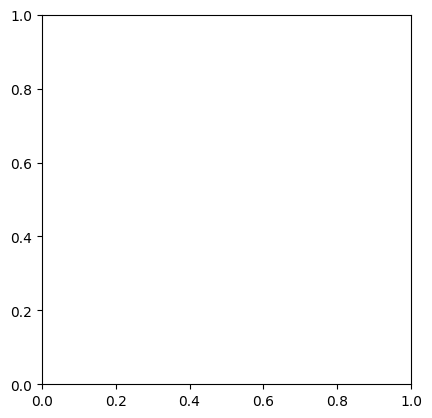

In [213]:
# Generate the JSON output file
if PAD_ENABLE:
    # these final bits of wiring up to the input pads don't need to be duplicated
    tracks_b.append(
        {
            "net": COIL_NET_NAME,
            "pts": [
                (pad_connection_point_x + PAD_WIDTH / 2, 0),
                (pad_connection_point_x, 0),
            ],
        }
    )
    tracks_b.append(
        {
            "net": COIL_NET_NAME,
            "pts": draw_arc(coil_angles[0], -pad_angle, pad_connection_point_x, 1),
        }
    )
    tracks_b.append(
        {
            "net": COIL_NET_NAME,
            "pts": draw_arc(coil_angles[2], pad_angle, pad_connection_point_x, 1),
        }
    )

nibble_angle_size = 360 * SCREW_HOLE_DRILL_DIAM / (2 * np.pi * STATOR_RADIUS)

if PCB_EDGE_CUTS:
    outer_cuts = (
        draw_arc(
            -45 + nibble_angle_size / 2, 45 - nibble_angle_size / 2, STATOR_RADIUS, 5
        )
        + translate(
            rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5)[::-1], 135),
            STATOR_RADIUS,
            45,
        )
        + draw_arc(
            45 + nibble_angle_size / 2, 135 - nibble_angle_size / 2, STATOR_RADIUS, 5
        )
        + translate(
            rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5), 225)[::-1],
            STATOR_RADIUS,
            135,
        )
        + draw_arc(
            135 + nibble_angle_size / 2, 225 - nibble_angle_size / 2, STATOR_RADIUS, 5
        )
        + translate(
            rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5), 315)[::-1],
            STATOR_RADIUS,
            225,
        )
        + draw_arc(
            225 + nibble_angle_size / 2, 315 - nibble_angle_size / 2, STATOR_RADIUS, 5
        )
        + translate(
            rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5), 45)[::-1],
            STATOR_RADIUS,
            315,
        )
    )

    edge_cuts = [
        outer_cuts,
        draw_arc(0, 360, STATOR_HOLE_RADIUS, 1),
    ]
else:
    edge_cuts = []


# Create Mounting Holes

# create_mounting_hole(,)

# def create_mounting_hole(point, diameter):
#     return {
#         "x": point[0],
#         "y": point[1],
#         "diameter": diameter,
#     }

# #Speed up iterating
# tracks_b = []
# tracks_f = []

# ax = None
# ax.set_xlim(-120, 120)
# ax.set_ylim(-120, 120)





import matplotlib.pyplot as plt
import numpy as np

# Parameters
radius = 80  # radius where the holes will be placed, in mm
hole_diameter = 3  # diameter of each hole, in mm
num_holes = 8  # number of holes to be equally spaced

# Create a figure and a subplot
fig, ax = plt.subplots()

# Calculate angle between holes in radians
angle_between_holes = 2 * np.pi / num_holes

# Generate hole positions
holes = []
for i in range(num_holes):
    angle = i * angle_between_holes  # angle for this hole
    x = radius * np.cos(angle)  # convert polar to Cartesian coordinates
    y = radius * np.sin(angle)
    holes.append({"x": x, "y": y, "diameter": hole_diameter})

# Plot each hole
for hole in holes:
    ax.add_patch(
        plt.Circle(
            (hole["x"], hole["y"]),
            radius=hole["diameter"] / 2,
            fill=False,
            color="orange",
        )
    )

# Setting equal aspect ratio to ensure circle shape
ax.set_aspect("equal")

# Show plot
plt.show()







# dump out the json version
json_result = dump_json(
    filename=f"coils_36_{STATOR_RADIUS}mm_V5.json",
    track_width=TRACK_WIDTH,
    pin_diam=PIN_DIAM,
    pin_drill=PIN_DRILL,
    via_diam=VIA_DIAM,
    via_drill=VIA_DRILL,
    vias=vias,
    pins=pins,
    pads=pads,
    silk=silk,
    tracks_f=tracks_f,
    tracks_in=tracks_in,
    tracks_b=tracks_b,
    mounting_holes=mounting_holes,
    edge_cuts=edge_cuts,
    components=components,
)

In [ ]:
# plot the json
plot_json(json_result)